# DSO 522: Applied Time Series Analysis for Forecasting

## Week 7: Exponential Smoothing

### Fall 2024

#### Instructor: Dr. Matteo Sesia

<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## Simple exponential smoothing

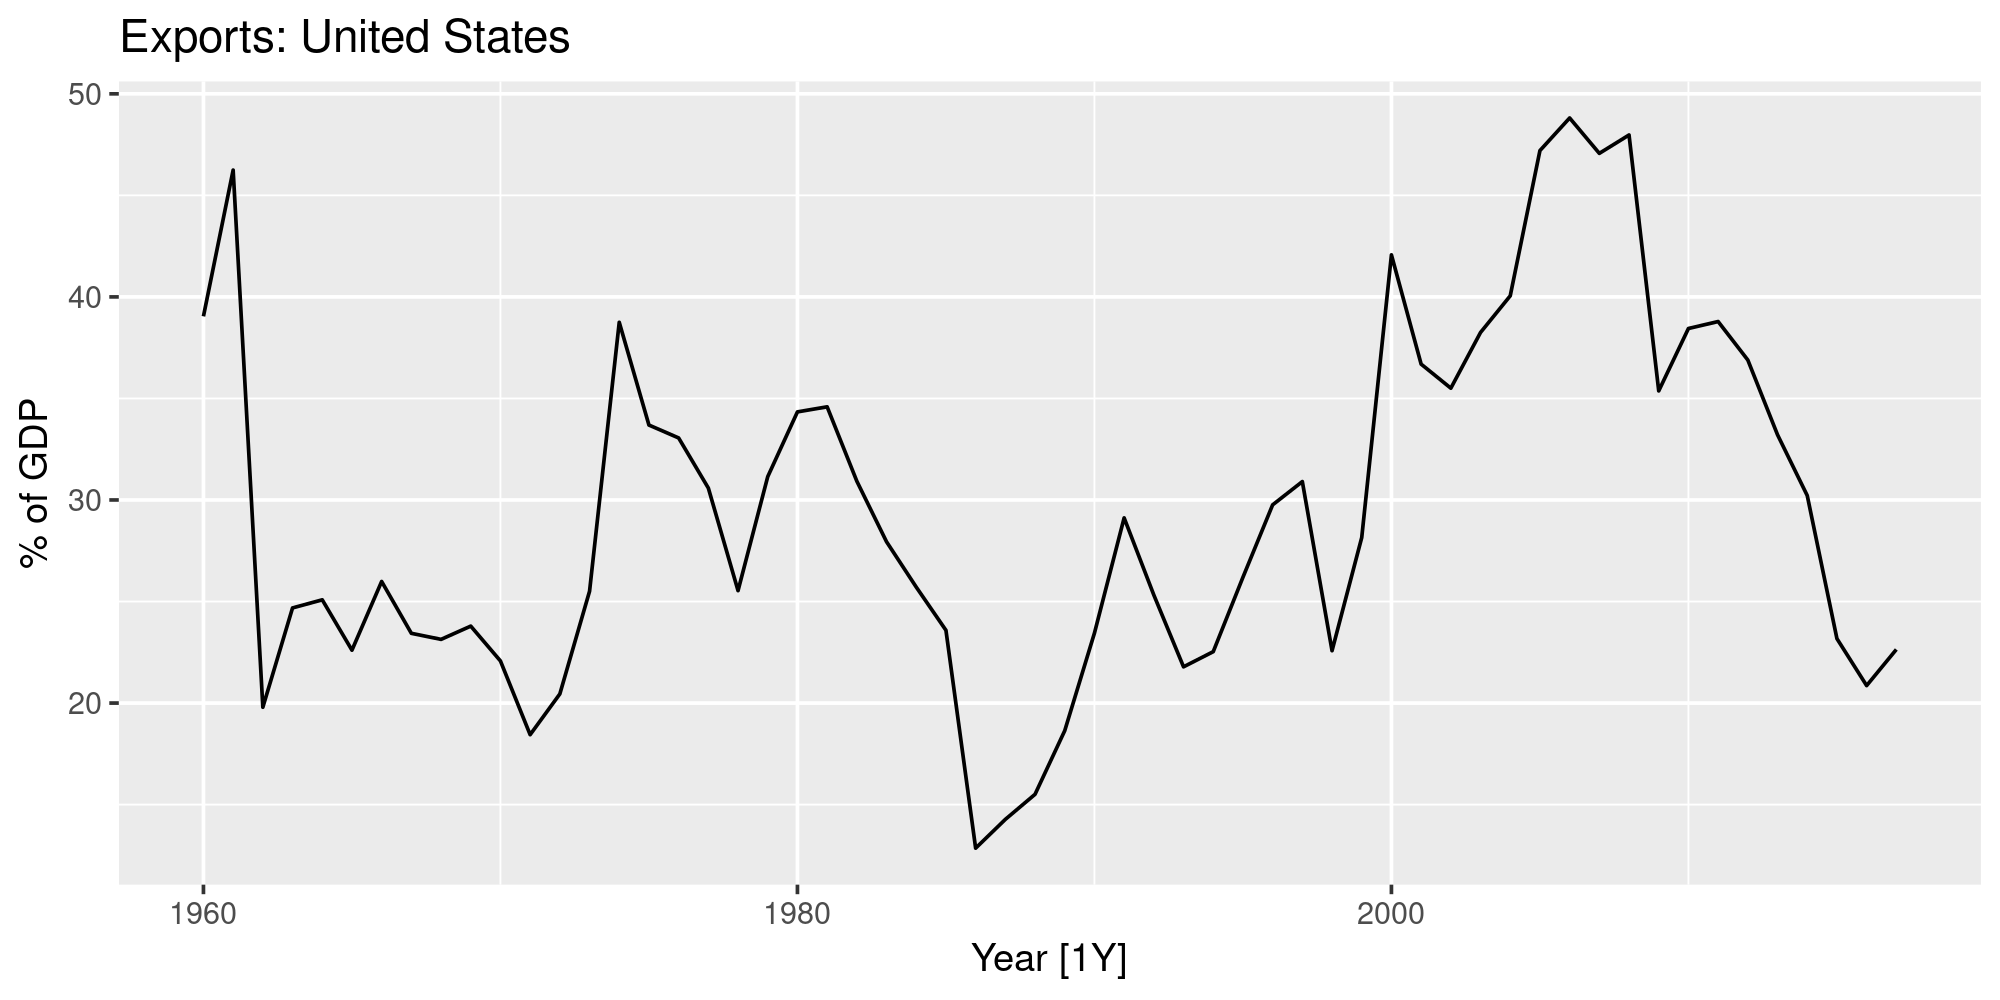

In [2]:
algeria_economy <- global_economy |>
  filter(Country == "Algeria")

algeria_economy |>
  autoplot(Exports) +
  labs(y = "% of GDP", title = "Exports: United States")

## Weighted average with exponentially decreasing weights

It may be sensible to attach larger weights to more recent observations than to observations from the distant past

\begin{equation}
  \hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,
\end{equation}

where $0 \leq \alpha \leq 1$ is the smoothing parameter.

For any $\alpha$ between 0 and 1, the weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”.

We present two equivalent forms of simple exponential smoothing.

## Weighted average form

The forecast at time $T+1$ is equal to a weighted average between the most recent observation $y_T$ and the previous forecast $\hat{Y}_{T \mid T-1}$:
$$\hat{y}_{T+1|T} = \alpha y_T + (1-\alpha) \hat{y}_{T|T-1}.$$

Similarly, we can write the fitted values as 
$$\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha) \hat{y}_{t|t-1}.$$

The process has to start somewhere, so we let the first fitted value at time 1 be denoted by $\ell_0$.

## Component form

The component form of simple exponential smoothing is given by:
\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}

where $\ell_t$ is the level (or the smoothed value) of the series at time $t$.

Setting $h=1$ gives the fitted values, while setting $t=T$ gives the true forecasts beyond the training data.

The component form of simple exponential smoothing is not particularly useful on its own, but it will be the easiest form to use when we start adding other components.

## Flat forecasts

Simple exponential smoothing has a “flat” forecast function: 
$$\hat{y}_{T+h|T} = \hat{y}_{T+1|T}=\ell_T, \qquad h=2,3,\dots.$$

## Optimisation

The application of every exponential smoothing method requires the smoothing parameters and the initial values to be chosen. In particular, for simple exponential smoothing, we need to select the values of $\alpha$ and $\ell_0$.

In some cases, the smoothing parameters may be chosen in a subjective manner — the forecaster specifies the value of the smoothing parameters based on previous experience. However, a more reliable and objective way to obtain values for the unknown parameters is to estimate them from the observed data.

Find the values of the unknown parameters and the initial values that minimise 
\begin{equation}
\text{SSE}=\sum_{t=1}^T(y_t - \hat{y}_{t|t-1})^2=\sum_{t=1}^Te_t^2. \tag{8.2}
\end{equation}

Unlike the regression case (where we have formulas which return the values of the regression coefficients that minimise the SSE), this involves a non-linear minimisation problem, and we need to use an optimisation tool to solve it.

## Example: Algerian exports

\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+1|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1}.
\end{align*}

Country,.model,term,estimate
<fct>,<chr>,<chr>,<dbl>
Algeria,"ETS(Exports ~ error(""A"") + trend(""N"") + season(""N""))",alpha,0.8399875
Algeria,"ETS(Exports ~ error(""A"") + trend(""N"") + season(""N""))",l[0],39.5389994


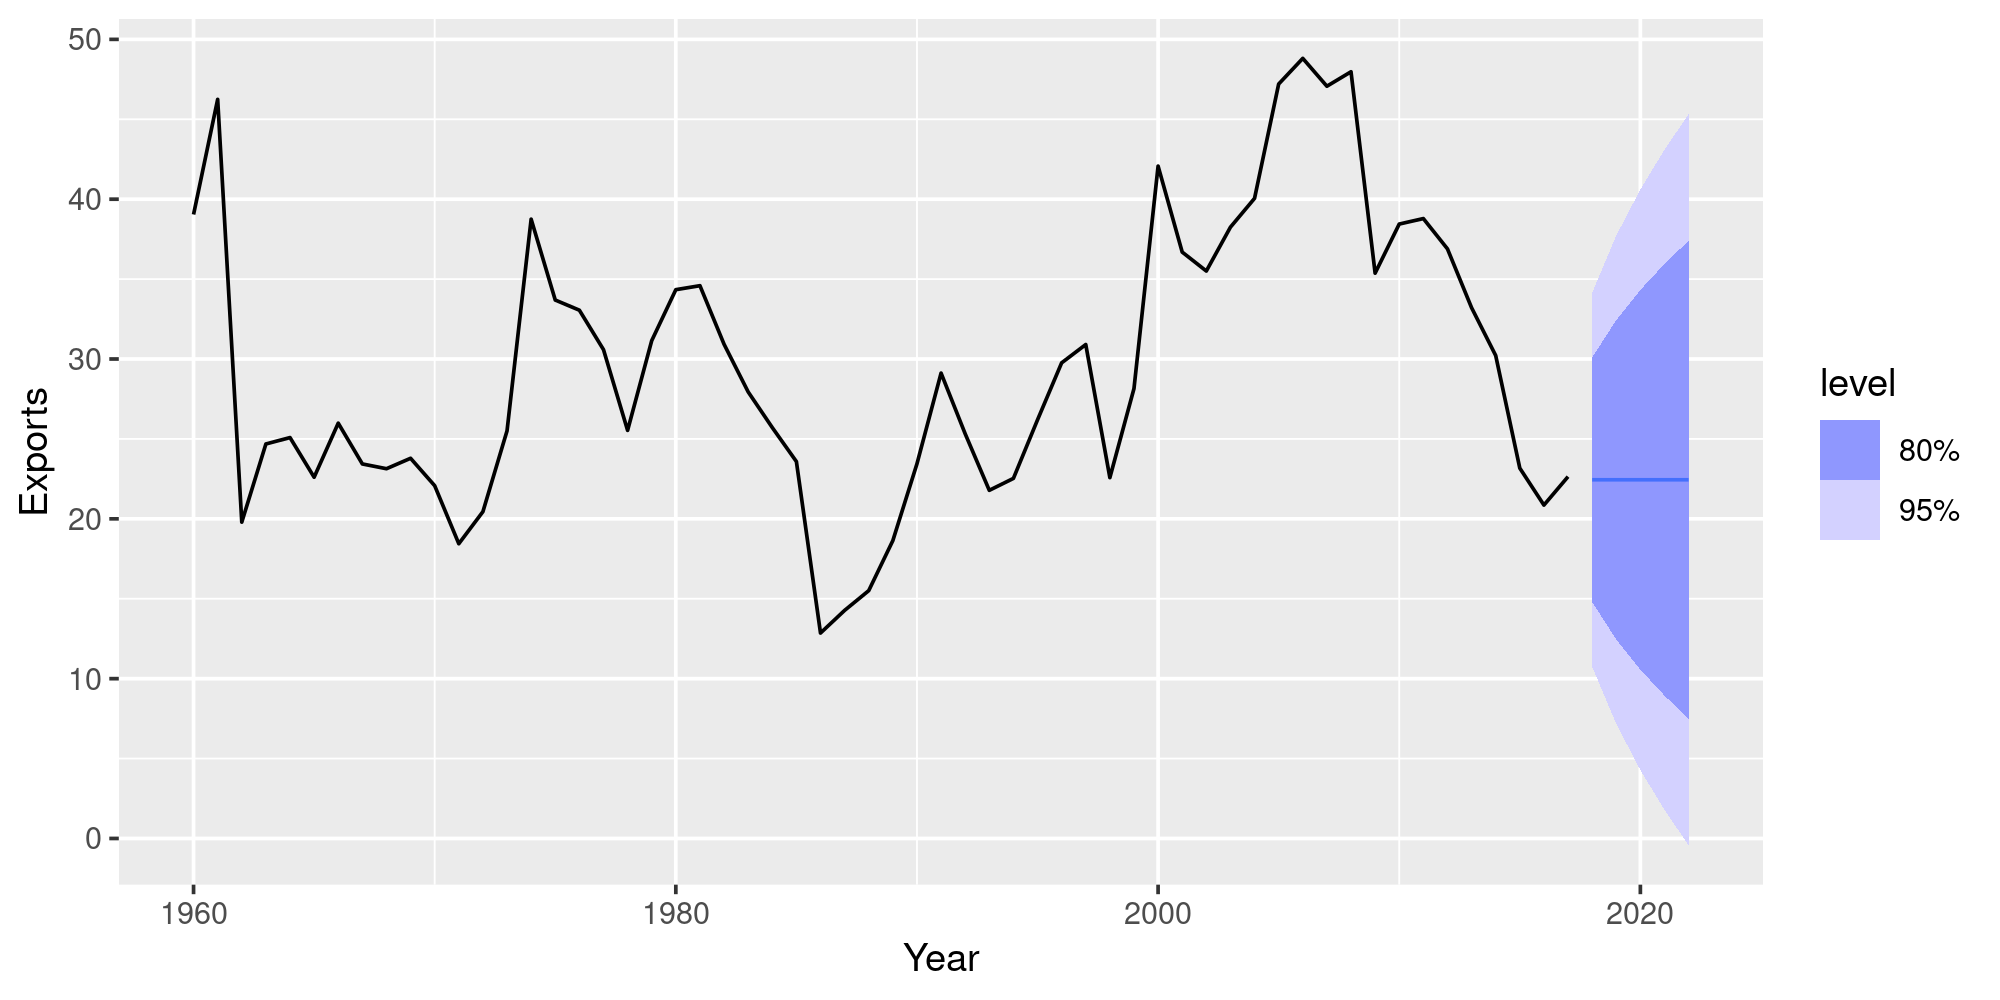

In [3]:
# Estimate parameters of ETS(A,N,N): simple exponential smoothing with additive errors
fit <- algeria_economy |> model(ETS(Exports ~ error("A") + trend("N") + season("N")))
fit |> tidy()
fc <- fit |> forecast(h = 5)
fc |> autoplot(algeria_economy) #+ geom_line(aes(y = .fitted), col="red", data = augment(fit))

## Exponential smoothing methods with trend

Simple exponential smoothing can be extended to allow the forecasting of data with a trend.

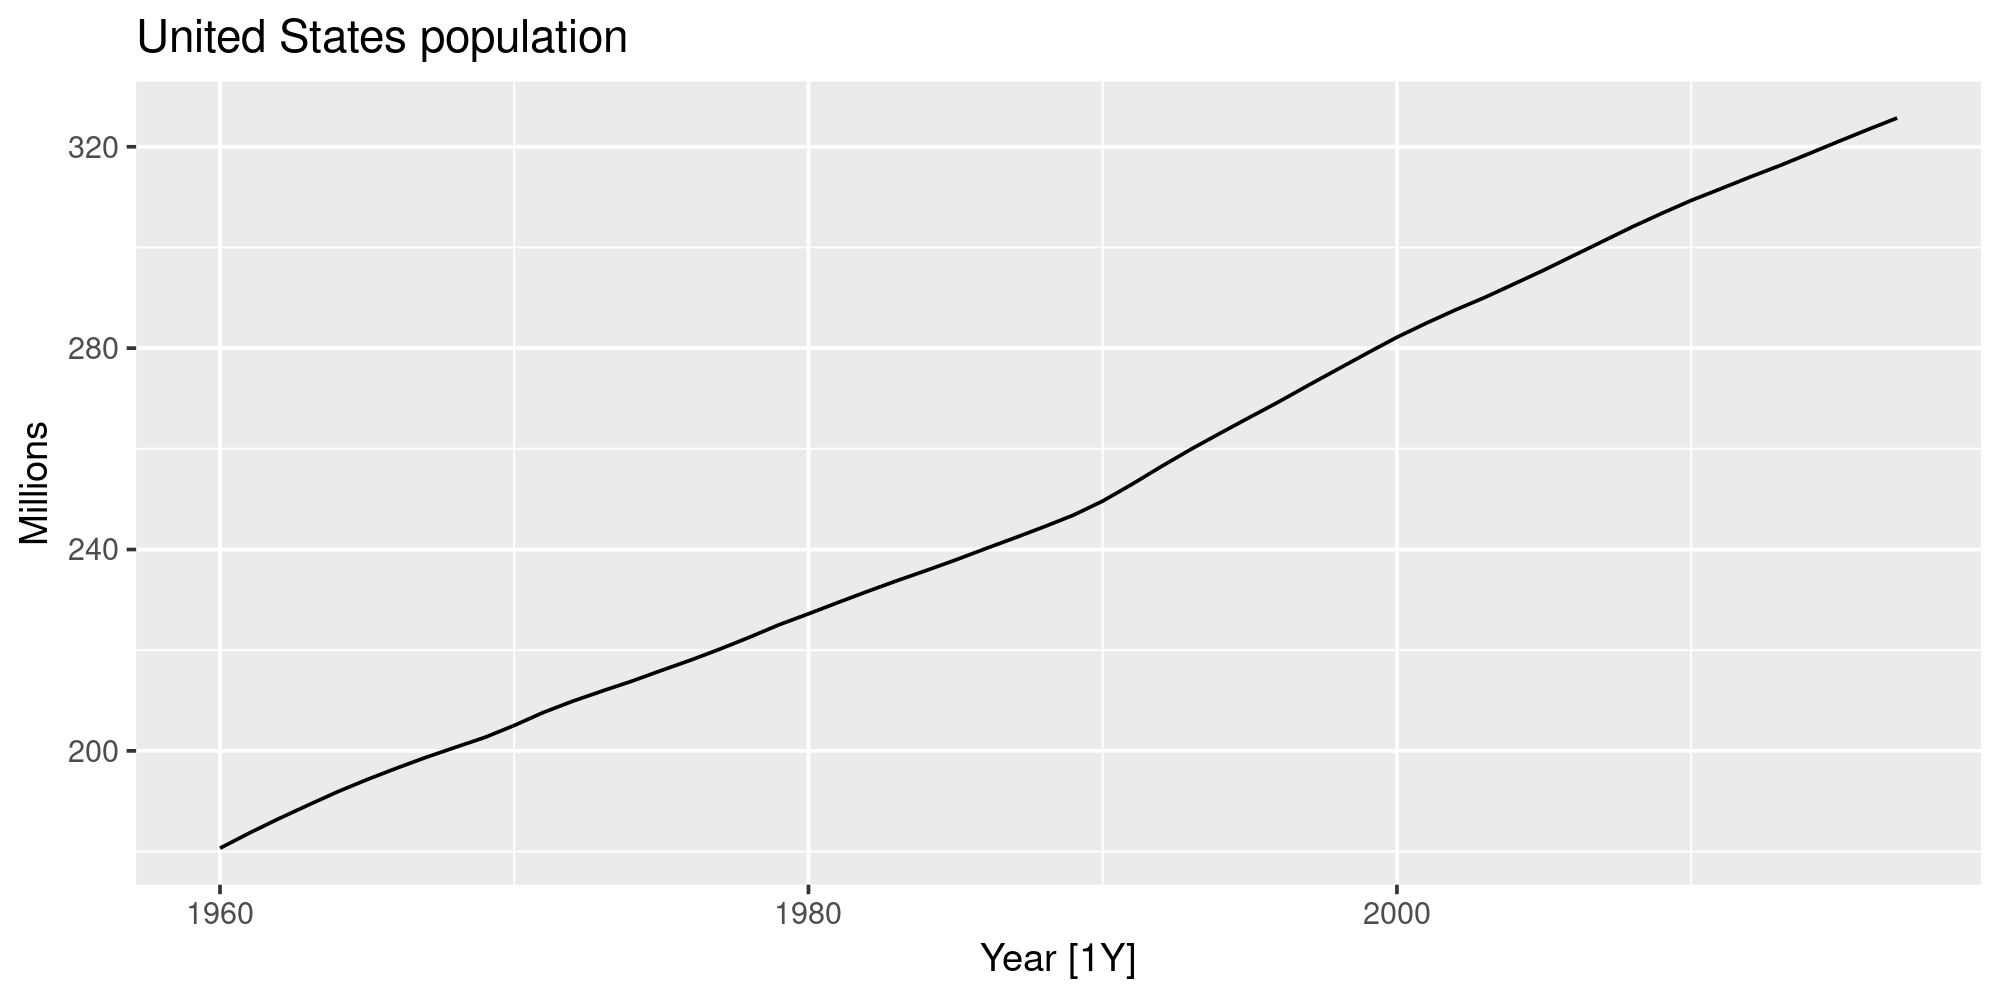

In [4]:
us_economy <- global_economy |>
  filter(Country == "United States") |>
  mutate(Pop = Population / 1e6)

autoplot(us_economy, Pop) +
  labs(y = "Millions", title = "United States population")

## Holt’s linear trend method (Holt, 1957) 

\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}

- $\ell_t$ is a weighted average of observation $y_t$ and the one-step-ahead training forecast for time $t$
- $b_t$ is a weighted average of the estimated trend at time $t$ based on $\ell_t - \ell_{t-1}$ and $b_{t−1}$, the previous estimate of the trend.

The forecast function is no longer flat but trending.

## Example: United States population

Country,.model,term,estimate
<fct>,<chr>,<chr>,<dbl>
United States,AAN,alpha,0.999900
United States,AAN,beta,0.999344
United States,AAN,l[0],177.649287
United States,AAN,b[0],3.022396


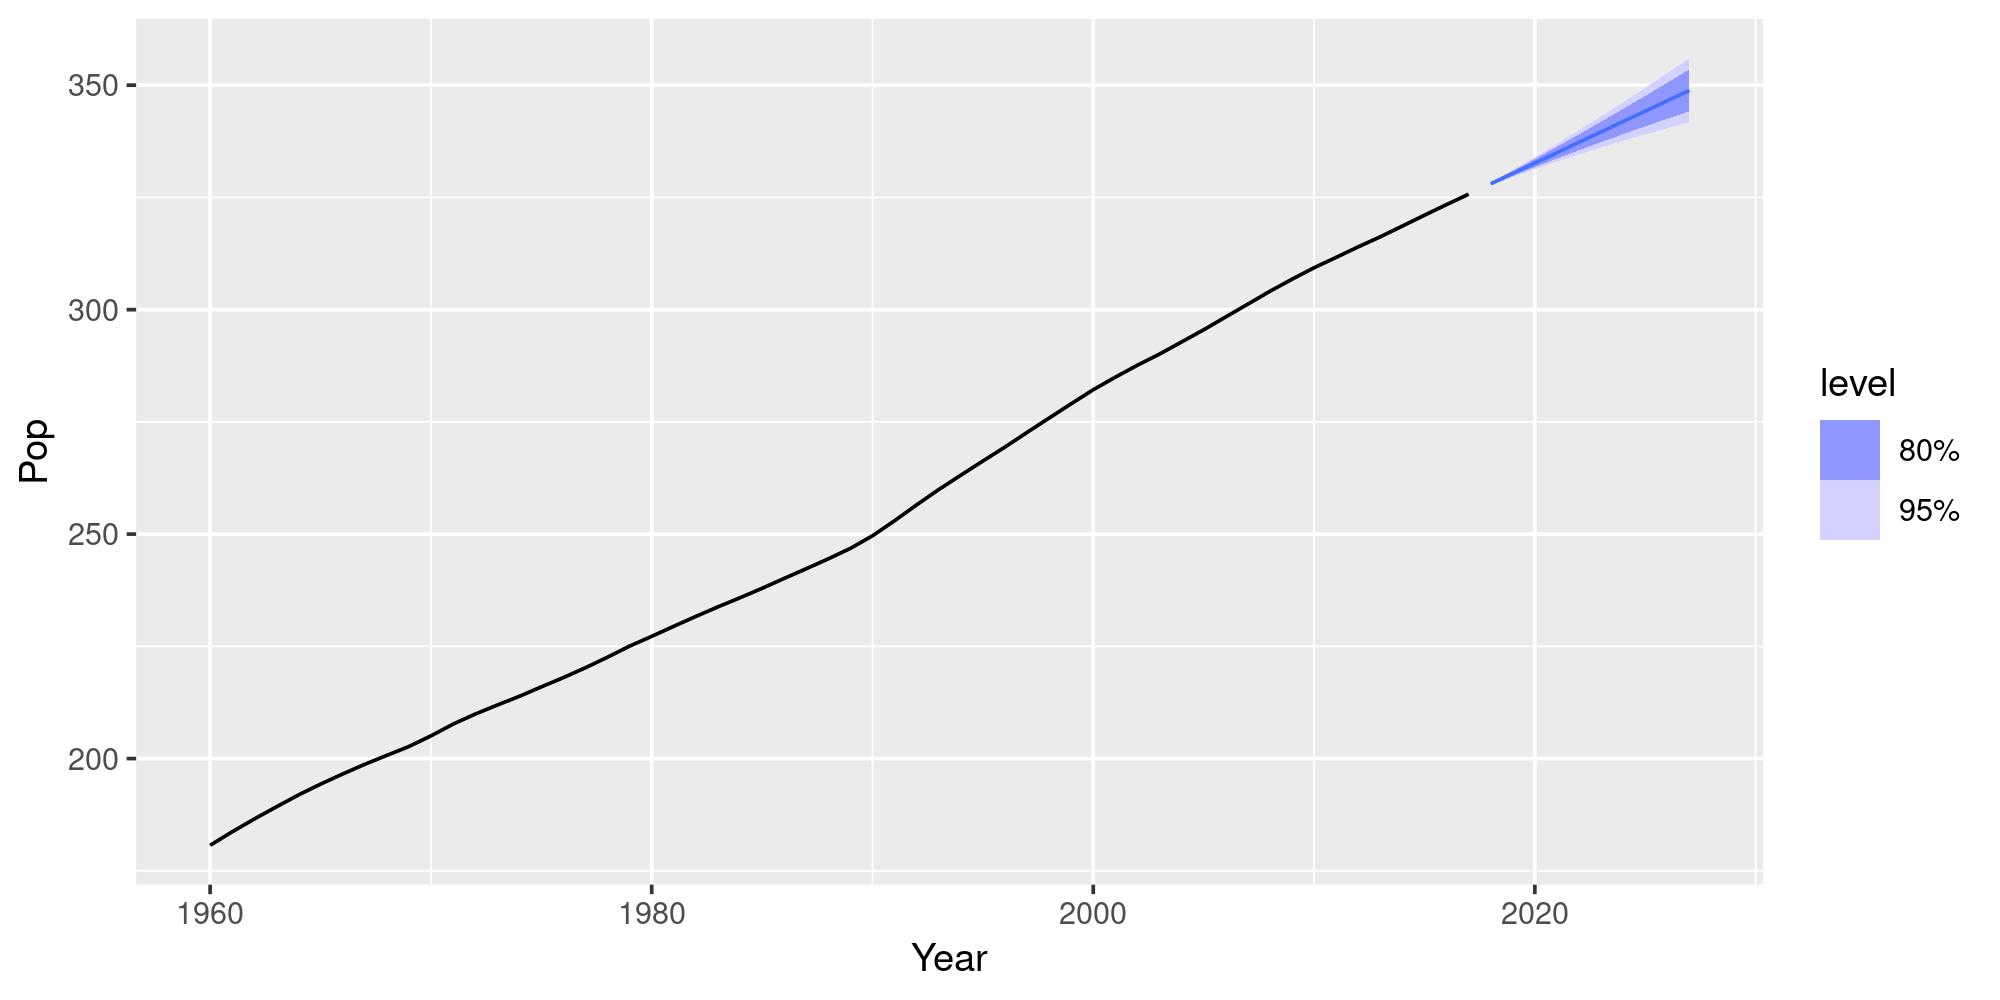

In [5]:
fit <- us_economy |> model(AAN = ETS(Pop ~ error("A") + trend("A") + season("N")))
fc <- fit |> forecast(h = 10)
fit |> tidy()
fc |> autoplot(us_economy) #+ geom_line(aes(y = .fitted), col="red", data = augment(fit))

## Damped trend methods (Gardner & McKenzie, 1985)

The forecasts generated by Holt’s linear method display a constant trend (increasing or decreasing) indefinitely into the future. Empirical evidence indicates that these methods tend to over-forecast, especially for longer forecast horizons.

Motivated by this observation, Gardner & McKenzie (1985) introduced a parameter that “dampens” the trend to a flat line some time in the future.

This method also includes a damping parameter $0<\phi<1$

\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + (\phi+\phi^2 + \dots + \phi^{h})b_{t} \\
  \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + \phi b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)\phi b_{t-1}.
\end{align*}

## Example: United States population

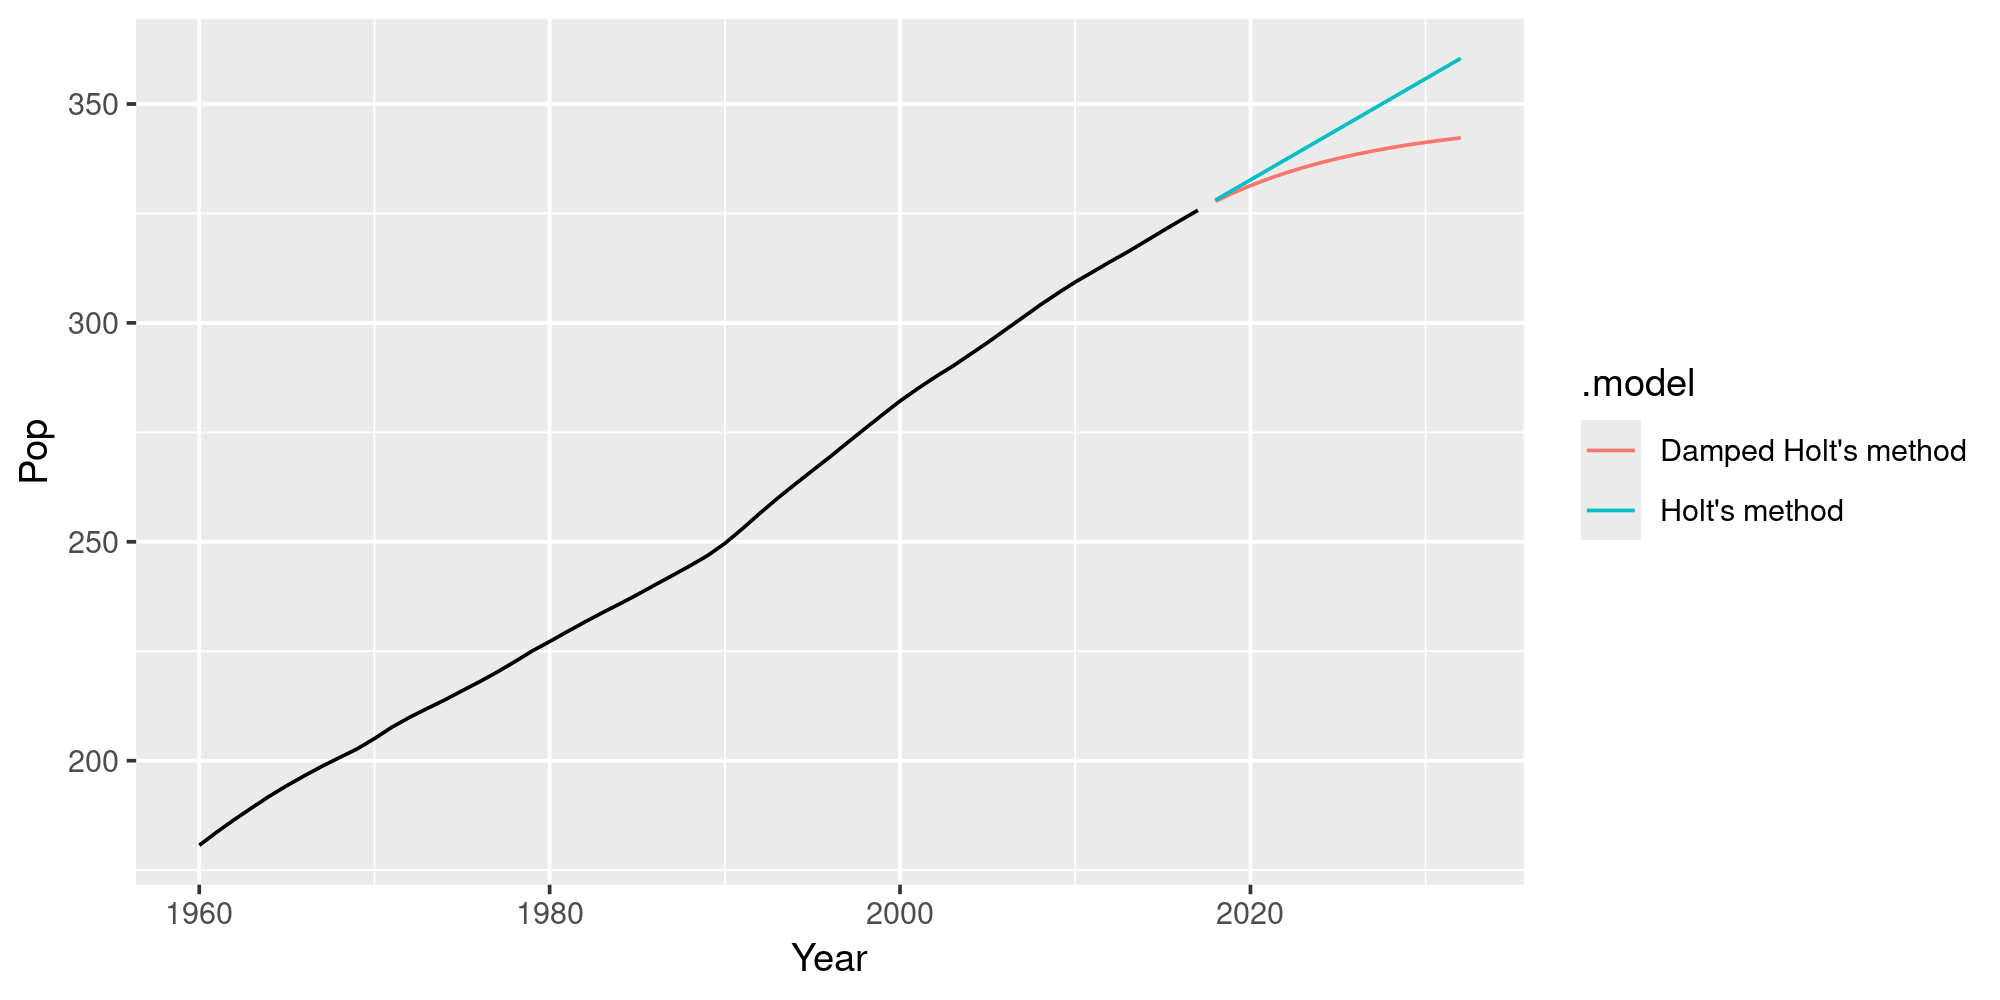

In [6]:
fit <- us_economy |> model(
    `Holt's method` = ETS(Pop ~ error("A") + trend("A") + season("N")),
    `Damped Holt's method` = ETS(Pop ~ error("A") + trend("Ad", phi = 0.9) + season("N"))
  )
fc <- fit |> forecast(h = 15)
fc |> autoplot(us_economy, level=NULL) #+ geom_line(aes(y = .fitted), col="red", data = augment(fit))

## Exponential smoothing methods with seasonality

Holt (1957) and Winters (1960) extended Holt’s method to capture seasonality. 

There are two variations to this method that differ in the nature of the seasonal component. The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series. 

## Example: Domestic overnight trips in Australia

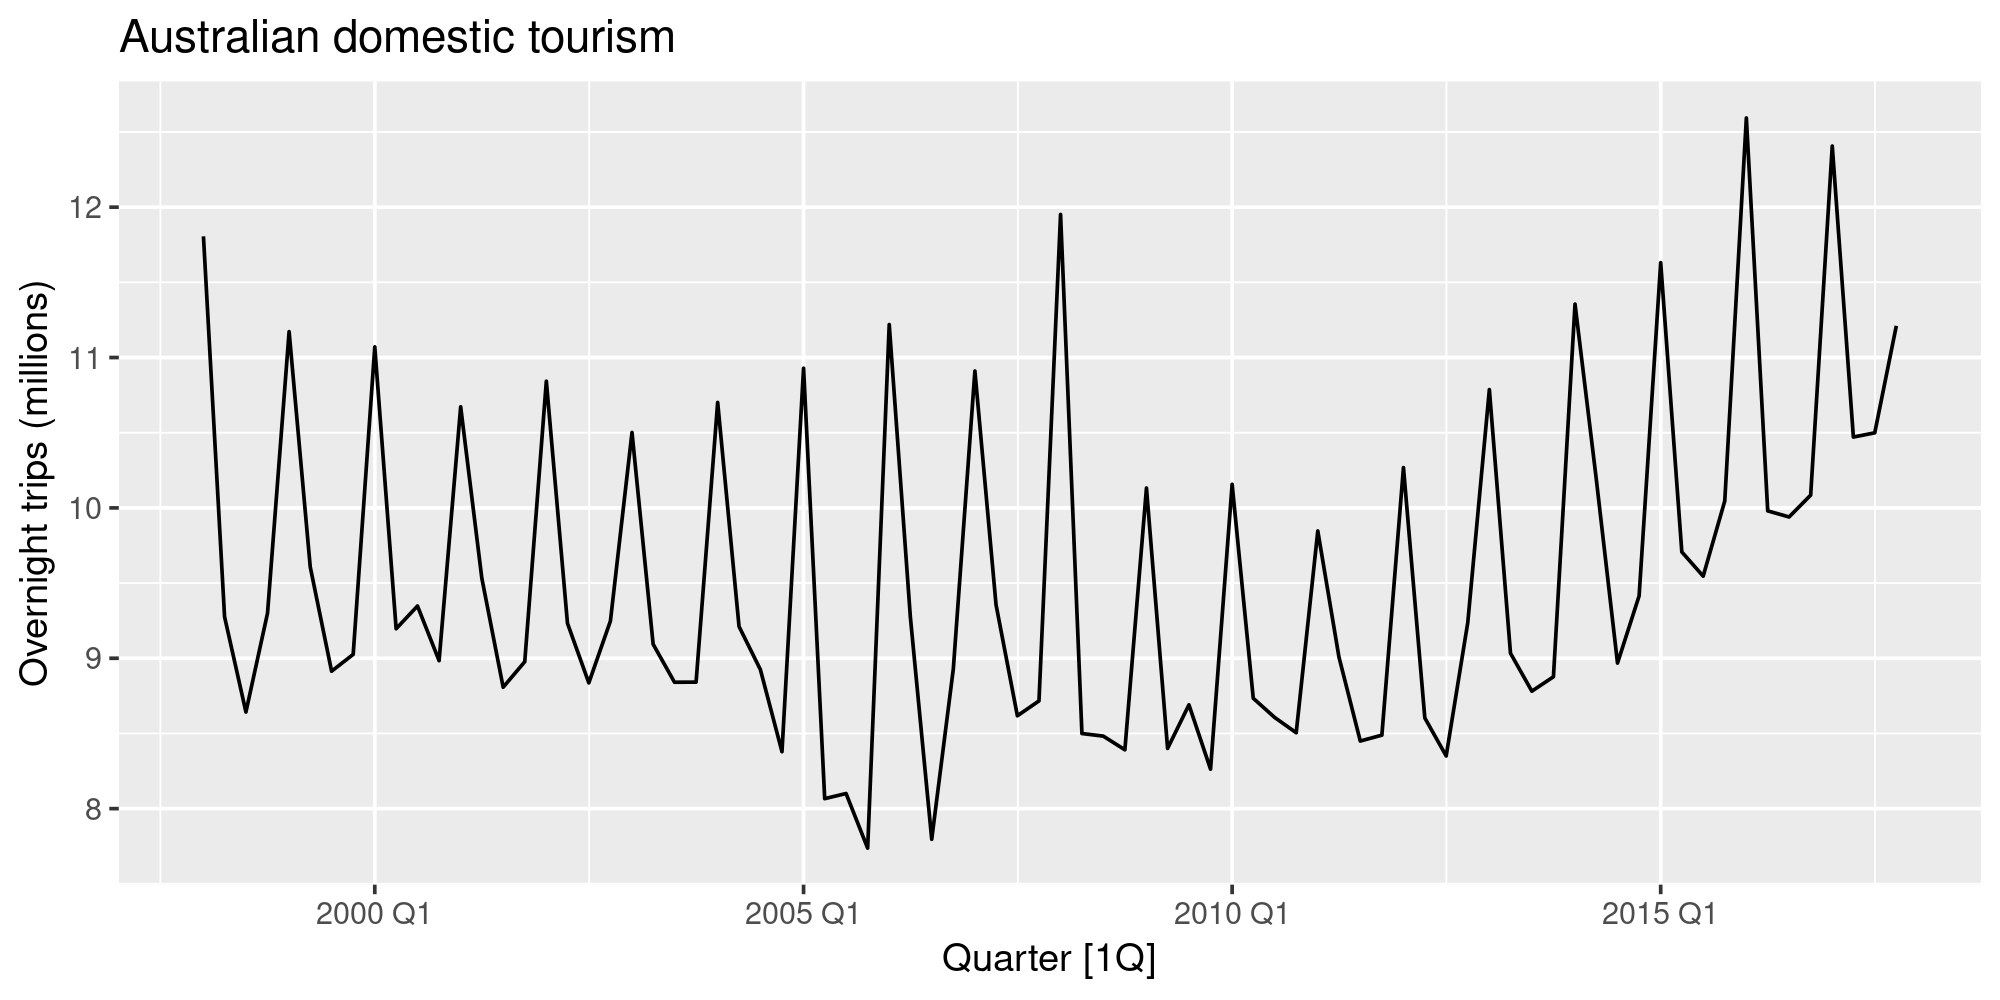

In [7]:
aus_holidays <- tourism |>
  filter(Purpose == "Holiday") |>
  summarise(Trips = sum(Trips)/1e3)

aus_holidays |>
    autoplot(Trips) +
      labs(title="Australian domestic tourism", y="Overnight trips (millions)") 

## Holt-Winters’ additive method

Seasonal period: $m$.

\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}

where $k$ is the integer part of $(h−1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the final year of the sample. 

- The level equation shows a weighted average between the seasonally adjusted observation $(y_t−s_{t-m})$ and the non-seasonal forecast $(\ell_{t−1}+b_{t−1})$ for time t
- The trend equation is identical to Holt’s linear method.
- The seasonal equation shows a weighted average between the current seasonal index and the seasonal index of the same season last year

## Example: Domestic overnight trips in Australia

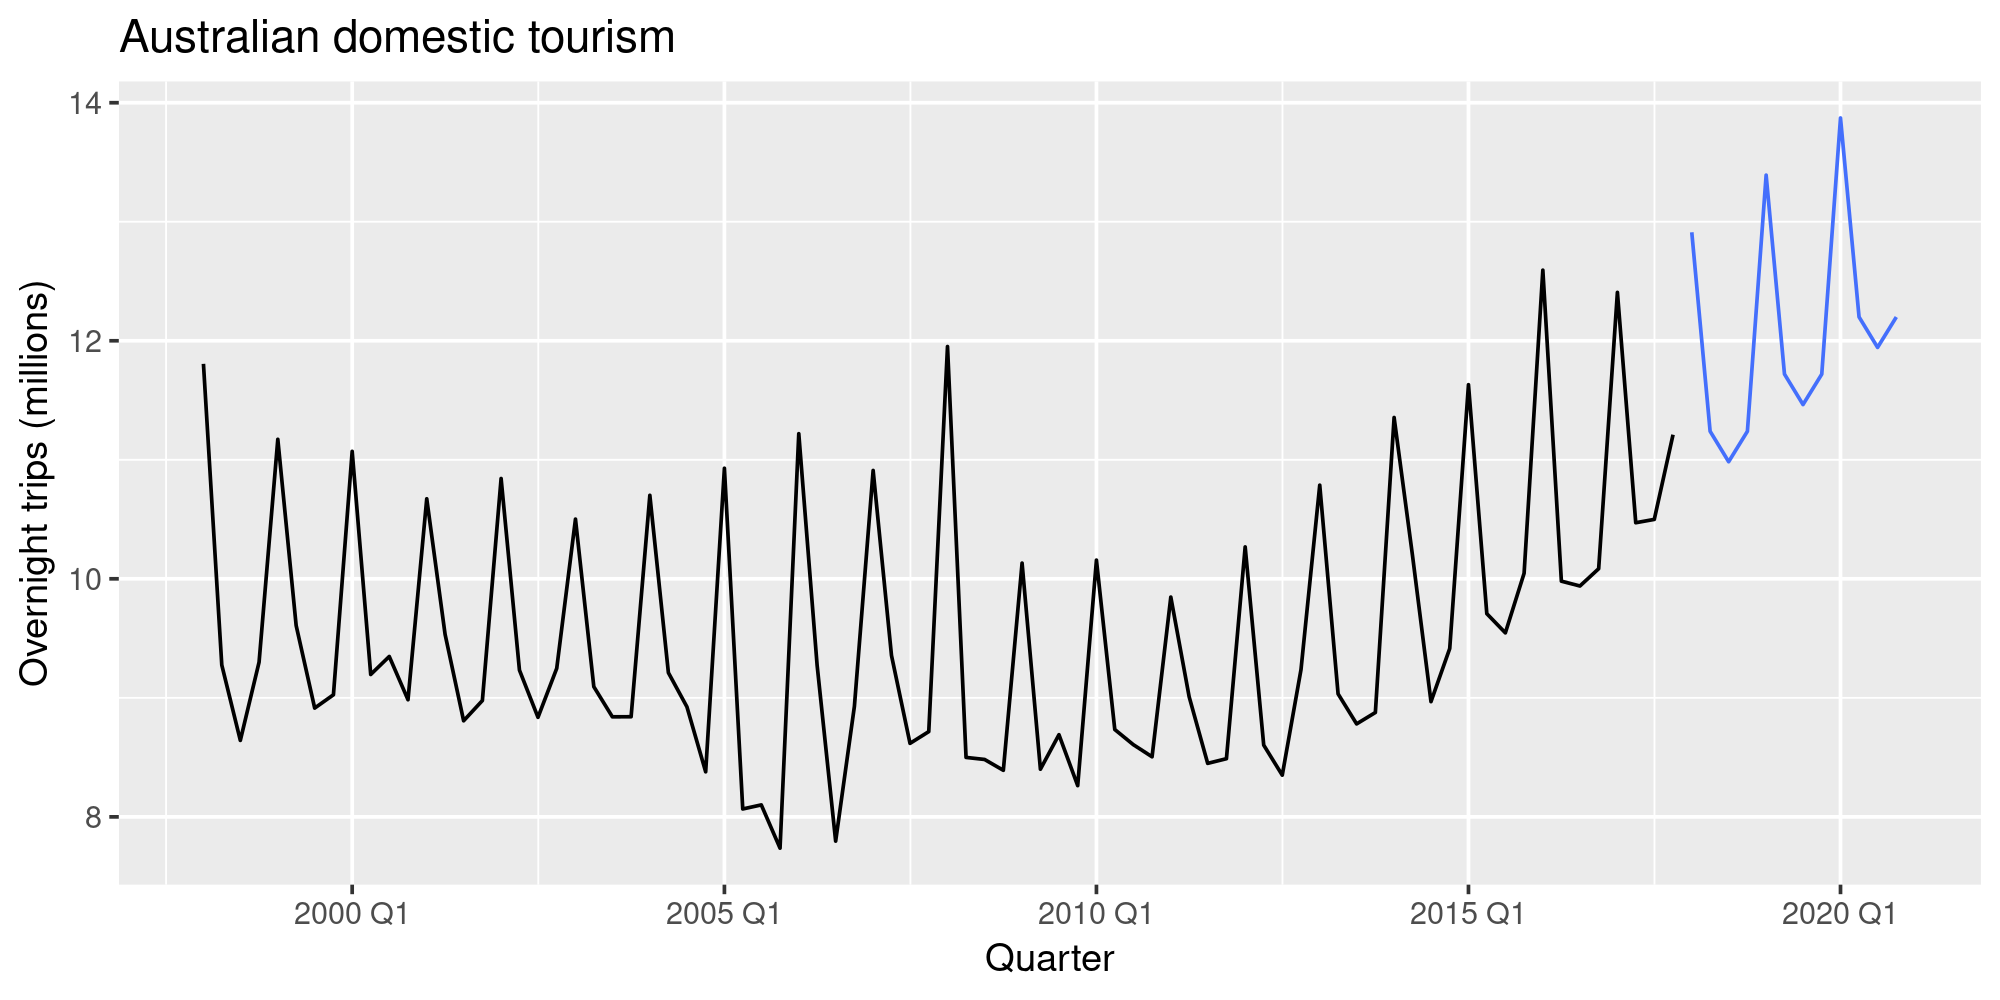

In [8]:
fit <- aus_holidays |>
  model(
    additive = ETS(Trips ~ error("A") + trend("A") + season("A"))
  )
fc <- fit |> forecast(h = "3 years")

fc |>
  autoplot(aus_holidays, level = NULL) +
  labs(title="Australian domestic tourism", y="Overnight trips (millions)") +
  guides(colour = guide_legend(title = "Forecast"))

## Holt-Winters’ multiplicative method

With the multiplicative method, the seasonal component is expressed in relative terms (percentages), and the series is seasonally adjusted by dividing through by the seasonal component. 

\begin{align*}
  \hat{y}_{t+h|t} &= (\ell_{t} + hb_{t})s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}                \\
  s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}.
\end{align*}

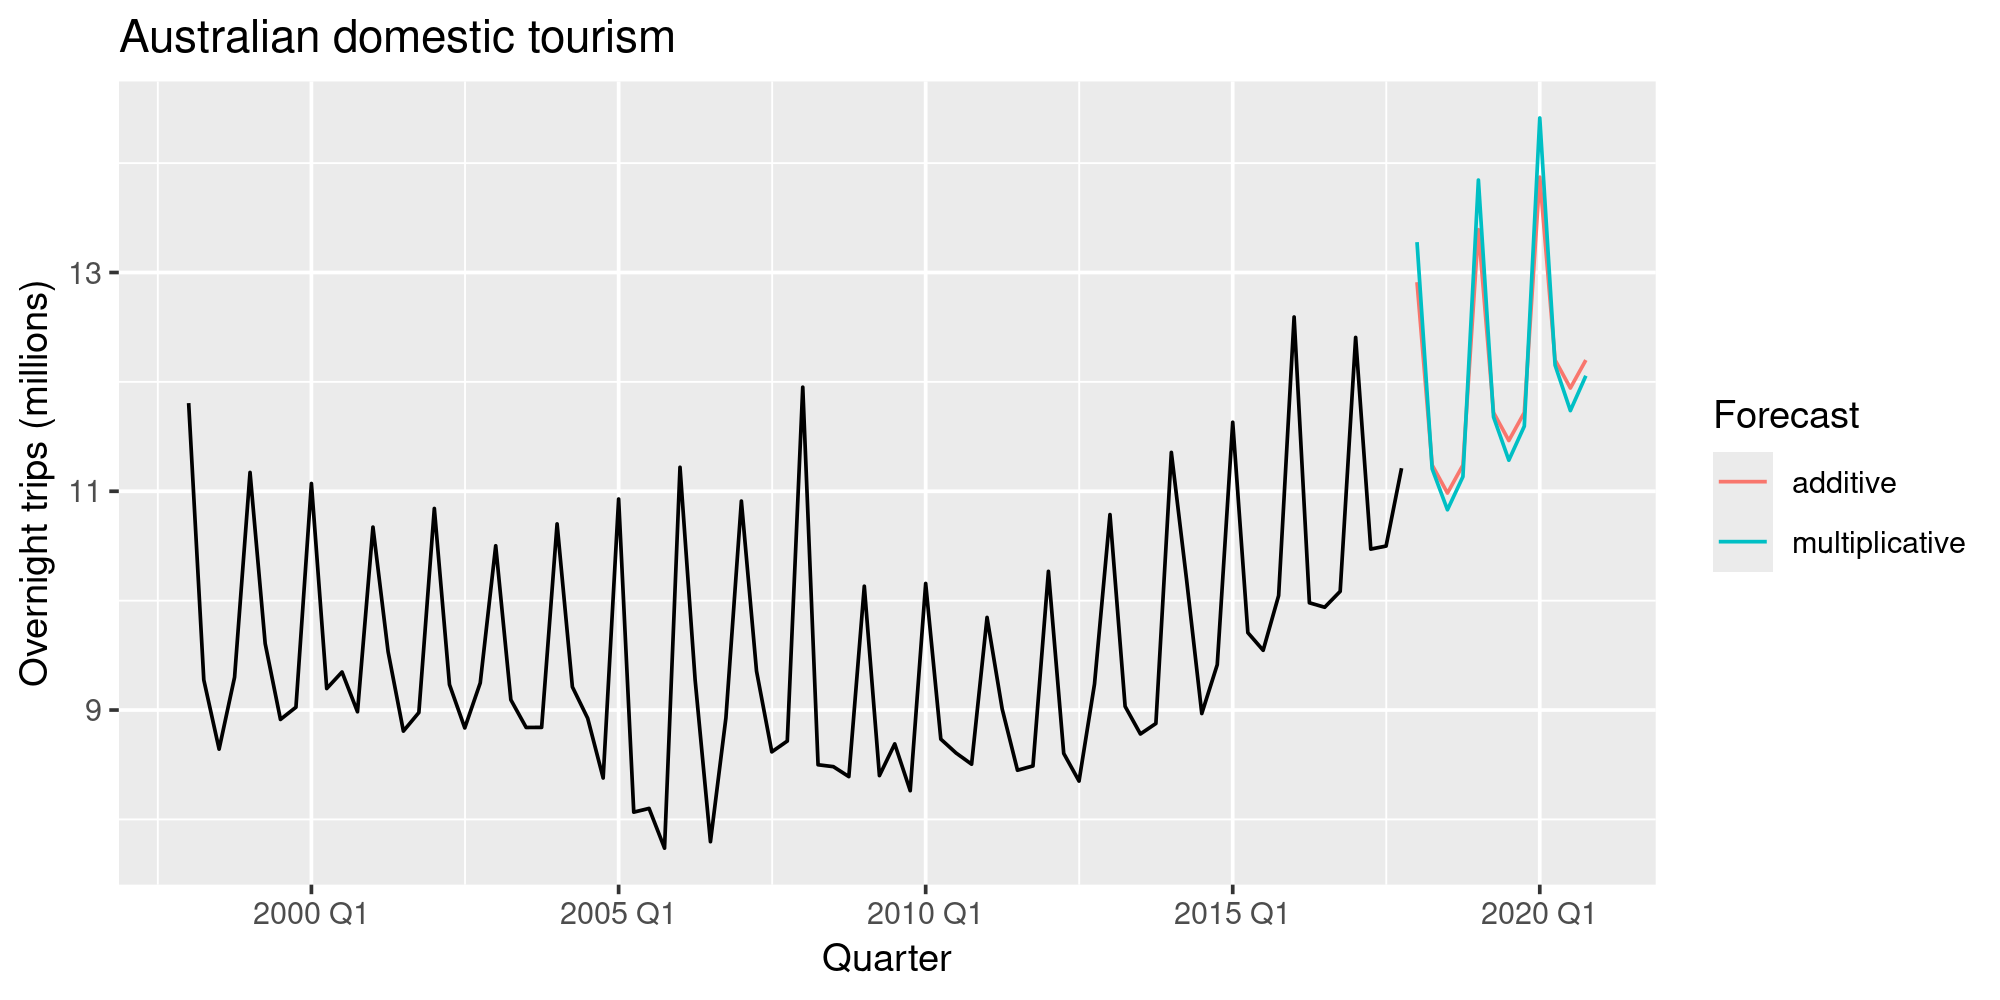

In [9]:
fit <- aus_holidays |>
  model(
    additive = ETS(Trips ~ error("A") + trend("A") + season("A")),
    multiplicative = ETS(Trips ~ error("M") + trend("A") + season("M")),
  )
fc <- fit |> forecast(h = "3 years")

fc |>
  autoplot(aus_holidays, level = NULL) +
  labs(title="Australian domestic tourism", y="Overnight trips (millions)") +
  guides(colour = guide_legend(title = "Forecast"))

## Holt-Winters’ damped method

Damping is possible with both additive and multiplicative Holt-Winters’ methods. 

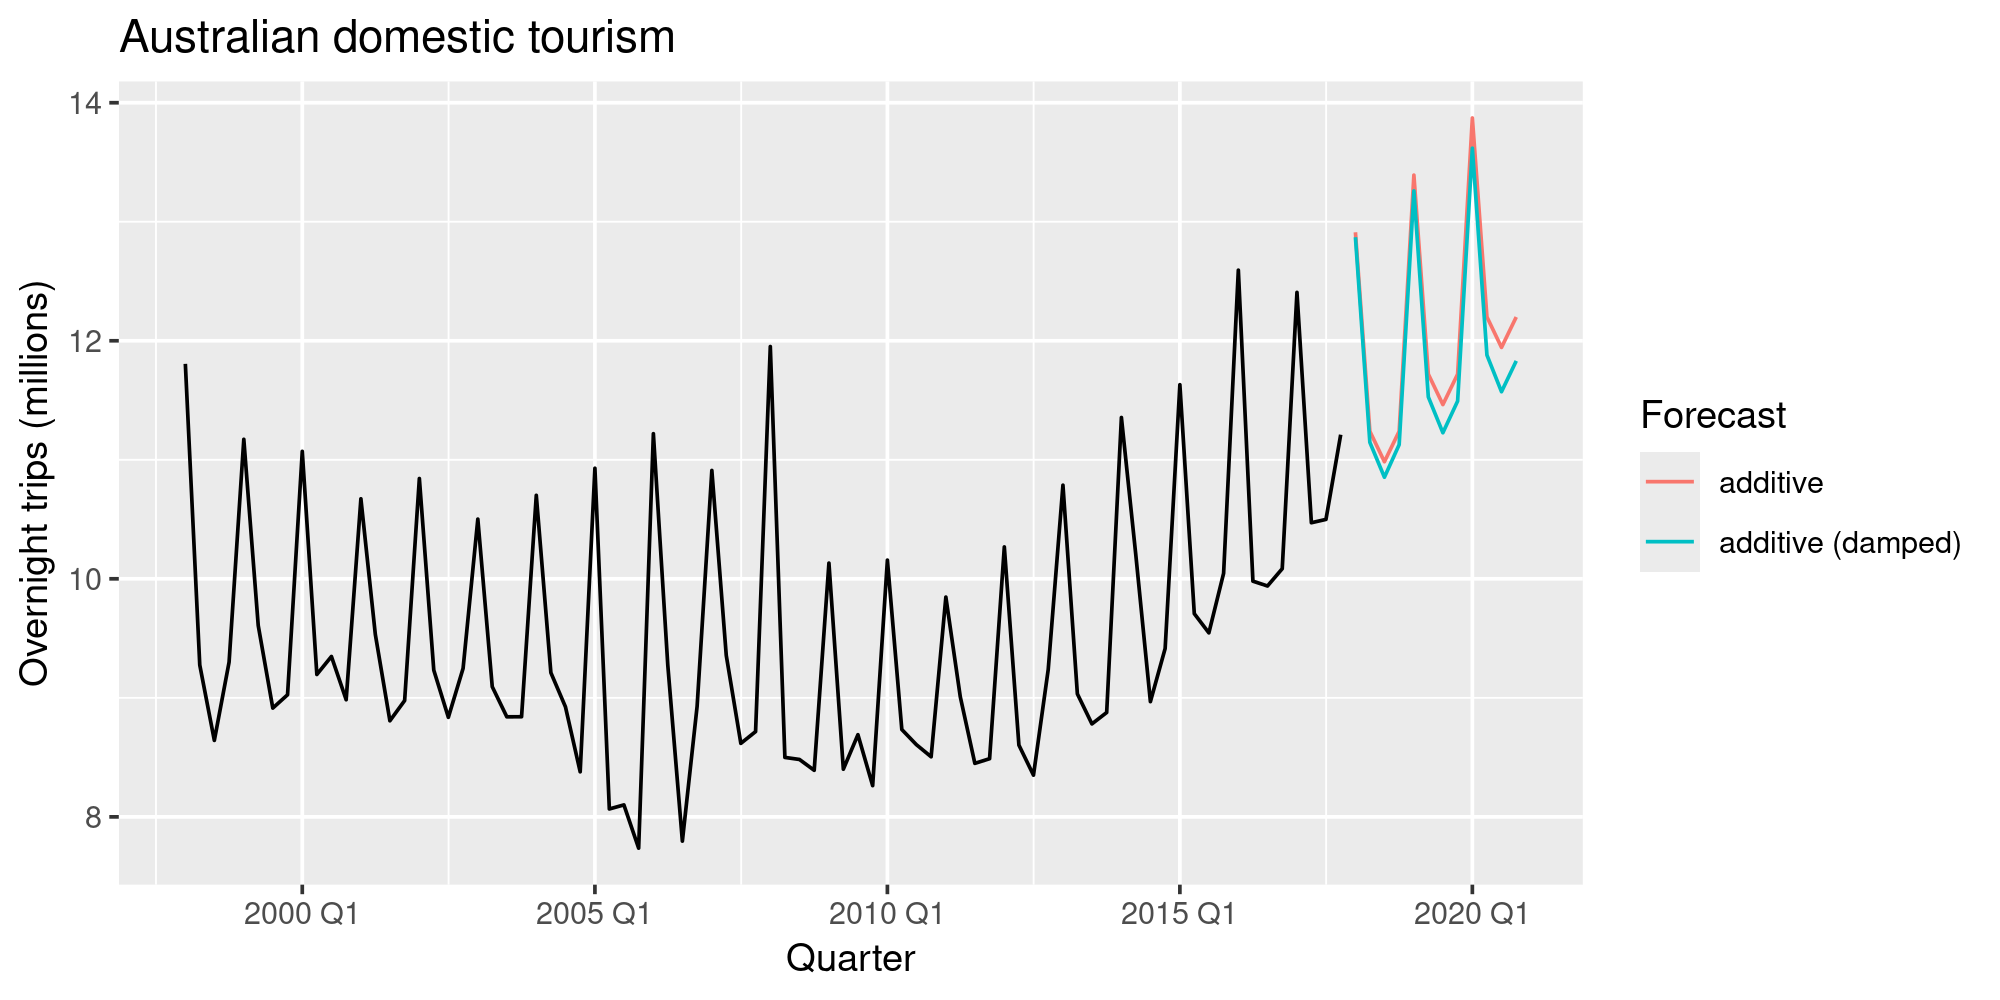

In [10]:
fit <- aus_holidays |>
  model(
    additive = ETS(Trips ~ error("A") + trend("A") + season("A")),
    `additive (damped)` = ETS(Trips ~ error("A") + trend("Ad") + season("A")),
  )
fc <- fit |> forecast(h = "3 years")

fc |>
  autoplot(aus_holidays, level = NULL) +
  labs(title="Australian domestic tourism", y="Overnight trips (millions)") +
  guides(colour = guide_legend(title = "Forecast"))

## A taxonomy of exponential smoothing methods

Exponential smoothing methods are not restricted to those we have presented so far. By considering variations in the combinations of the trend and seasonal components, nine exponential smoothing methods are possible.


<p align="center">
  <img src="img/exp-taxonomy.png" alt="Exponential smoothing methods" width="900"/>
</p>

<p align="center">
  <img src="img/exp-taxonomy-2.png" alt="Exponential smoothing methods" width="900"/>
</p>

We do not consider the multiplicative trend methods as they tend to produce poor forecasts.

## Model selection

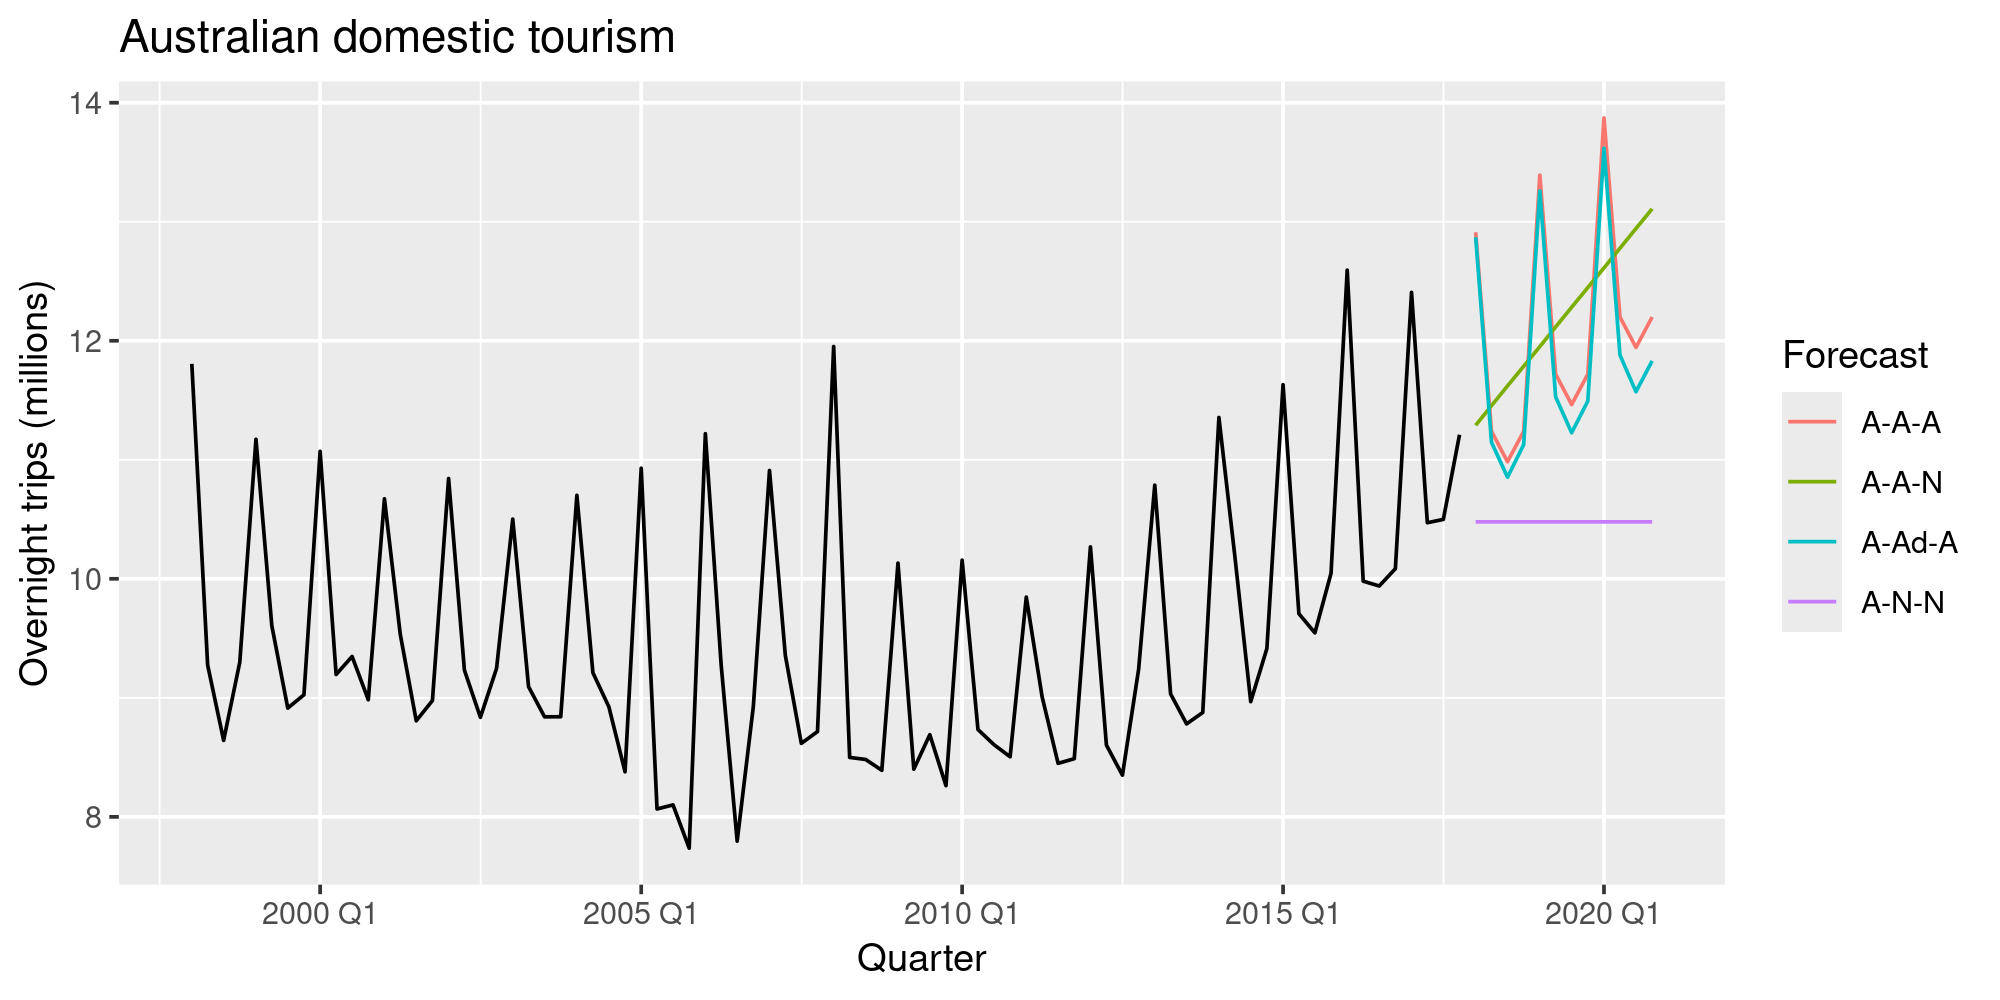

In [11]:
fit <- aus_holidays |>
  model(
    `A-N-N` = ETS(Trips ~ error("A") + trend("N") + season("N")),
    `A-A-N` = ETS(Trips ~ error("A") + trend("A") + season("N")),
    `A-A-A` = ETS(Trips ~ error("A") + trend("A") + season("A")),
    `A-Ad-A` = ETS(Trips ~ error("A") + trend("Ad") + season("A")),
  )
fc <- fit |> forecast(h = "3 years")

fc |>
  autoplot(aus_holidays, level = NULL) +
  labs(title="Australian domestic tourism", y="Overnight trips (millions)") +
  guides(colour = guide_legend(title = "Forecast"))

## Model selection via Information Criteria

Three criteria (to minimize), which balance between goodness of fit (higher is better) and model complexity (lower is better):

- AIC (Akaike’s Information Criterion)
- **AICc** (AIC corrected for small sample bias, often preferred)
- BIC (Bayesian Information Criterion)

Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are ETS(A,N,M), ETS(A,A,M), and ETS(A,Ad,M), due to division by values potentially close to zero. We normally do not consider these particular combinations when selecting a model.

In [12]:
fit <- aus_holidays |>
  model(
    `A-N-N` = ETS(Trips ~ error("A") + trend("N") + season("N")),
    `A-A-N` = ETS(Trips ~ error("A") + trend("A") + season("N")),
    `A-A-A` = ETS(Trips ~ error("A") + trend("A") + season("A")),
    `A-Ad-A` = ETS(Trips ~ error("A") + trend("Ad") + season("A")),
  )
fit |> glance() |> select(.model, AIC, AICc, BIC, MSE, MAE)

.model,AIC,AICc,BIC,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A-N-N,367.3265,367.6423,374.4726,1.1440277,0.8427135
A-A-N,363.9252,364.7360,375.8353,1.0429344,0.7680313
A-A-A,228.5676,231.1390,250.0058,0.1737858,0.3209553
A-Ad-A,229.1833,232.3717,253.0036,0.1708046,0.3159996


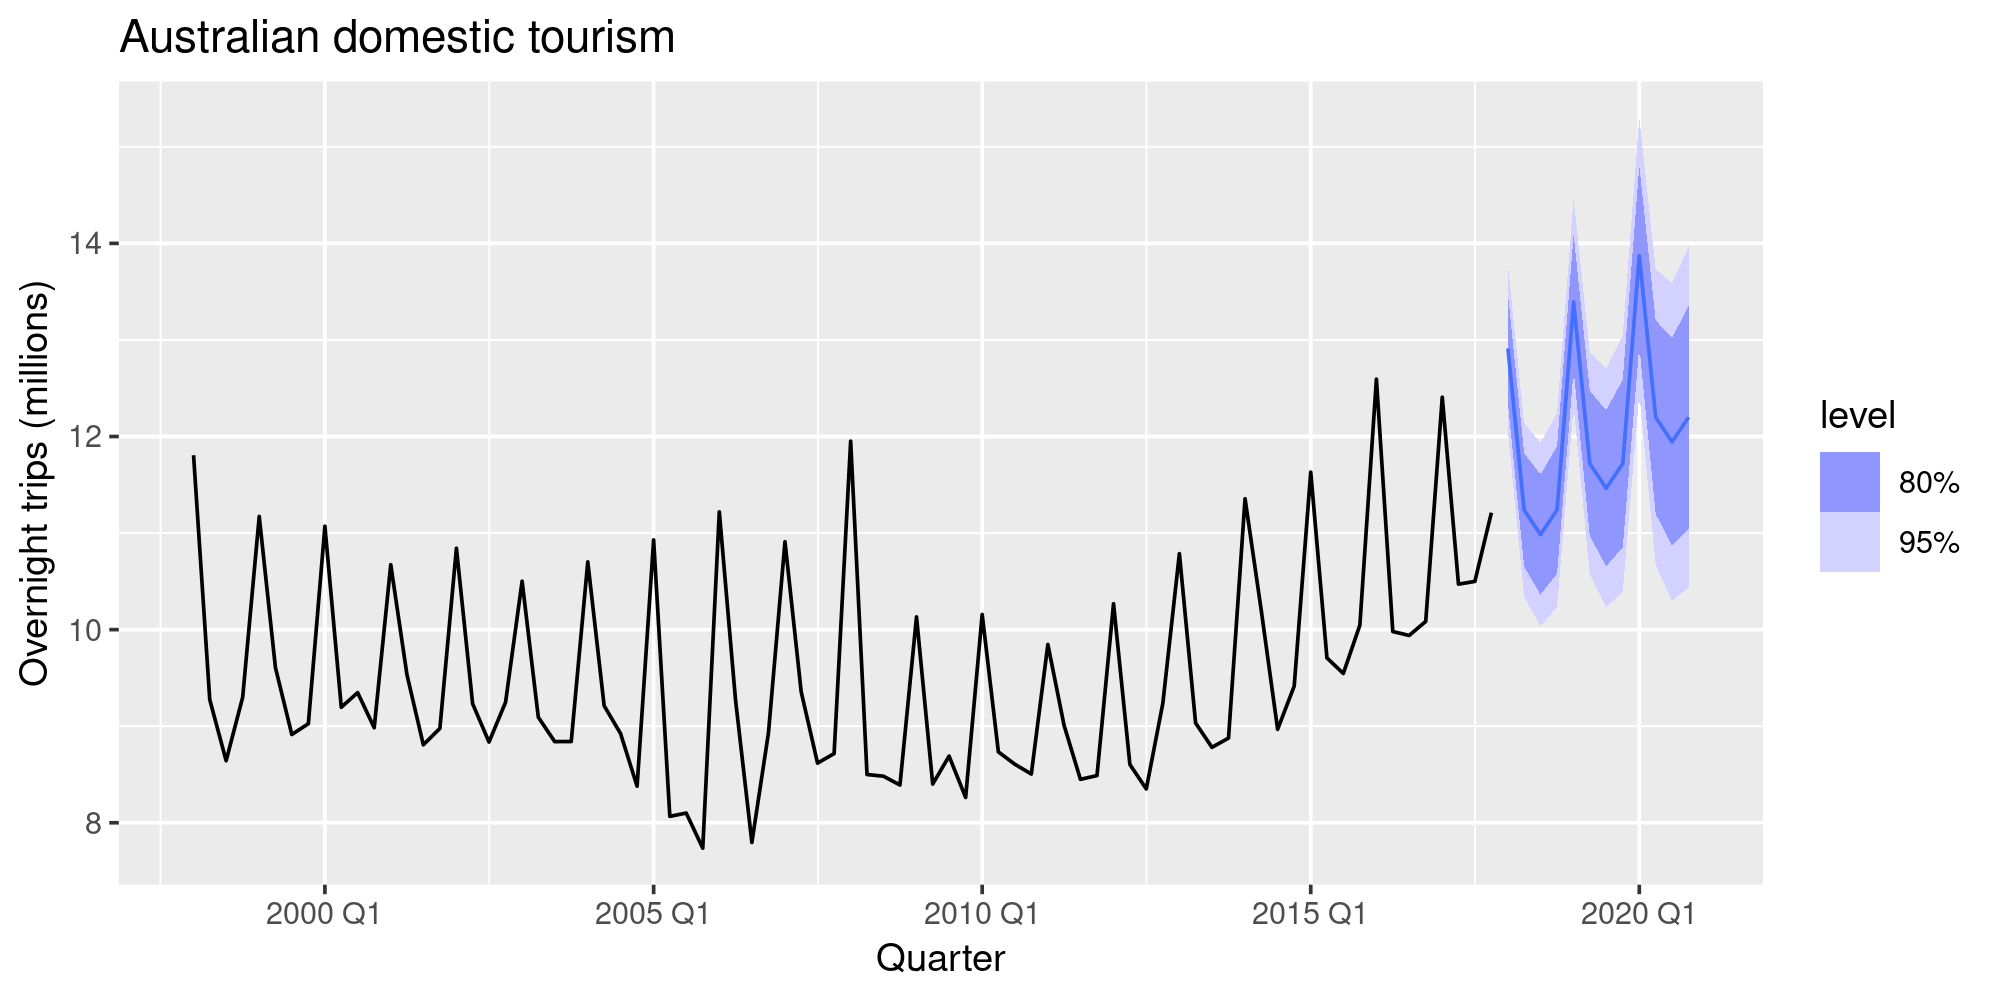

In [13]:
fit <- aus_holidays |>
  model(
    `A-N-N` = ETS(Trips ~ error("A") + trend("N") + season("N")),
    `A-A-N` = ETS(Trips ~ error("A") + trend("A") + season("N")),
    `A-A-A` = ETS(Trips ~ error("A") + trend("A") + season("A")),
    `A-Ad-A` = ETS(Trips ~ error("A") + trend("Ad") + season("A")),
  )
fc <- fit |> forecast(h = "3 years")

fc |>
  filter(.model=="A-A-A") |>
  autoplot(aus_holidays) +
  labs(title="Australian domestic tourism", y="Overnight trips (millions)") +
  guides(colour = guide_legend(title = "Forecast"))

## Guided Workbook

## Next time

- Midterm Exam (1.5 hours)
- Hands-on Case Studies